In [117]:
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F

In [92]:
csv = pd.read_csv('./converted/2000_converted_relative.csv')
data = []
for i in range(len(csv)):
    row = csv.iloc[i]
    if isinstance(row[3], float): continue # skip if no chords
    raw_chords = row[3].split()
    if len(raw_chords) < 6: continue # skip if chords shorter than 6
    chords = ''
    for chord in raw_chords:
        chords += ' ' + ('maj-' if row[2] == 0 else 'min-')
        chords += chord
    data.append(chords)

In [93]:
def create_seq(input, seq_len = 5):
    sequences = []
    if len(input.split()) > seq_len:
        for i in range(seq_len, len(input.split())):
            seq = input.split()[i - seq_len : i + 1]
            sequences.append(' '.join(seq))
        return sequences
    else:
        return [input]

In [95]:
seqs = [create_seq(chords) for chords in data]
seqs = sum(seqs, [])
print(f'number of sequences: {len(seqs)}')

number of sequences: 69169


In [96]:
# create inputs and targets (x, y)
x = []
y = []
for s in seqs:
    x.append(' '.join(s.split()[:-1]))
    y.append(' '.join(s.split()[1:]))

In [101]:
# int-to-token mapping
int2token = {}
cnt = 0
for w in set(' '.join(data).split()):
    int2token[cnt] = w
    cnt += 1

# token-to-int mapping
token2int = {t: i for i, t in int2token.items()}

print(len(int2token))
vocab_size = len(int2token)

581


In [99]:
def get_integer_seq(seq):
    return [token2int[w] for w in seq.split()]

# convert input/target seqs to int
x_int = [get_integer_seq(i) for i in x]
y_int = [get_integer_seq(i) for i in y]

# convert seqs to numpy arrays
x_int = np.array(x_int)
y_int = np.array(y_int)
print(x_int)

[[386   5 427 386 386]
 [  5 427 386 386   5]
 [427 386 386   5 311]
 ...
 [235 235 161 190 235]
 [235 161 190 235 161]
 [161 190 235 161 138]]


In [100]:
def get_batches(arr_x, arr_y, batch_size):
    prv = 0
    for n in range(batch_size, arr_x.shape[0], batch_size):
        x = arr_x[prv : n, :]
        y = arr_y[prv : n, :]
        prv = n
        yield x, y

In [102]:
class WordLSTM(nn.Module):
    def __init__(self, n_hidden=256, n_layers=4, drop_prob=0.3, lr=0.001):
        super().__init__()
        self.n_hidden = n_hidden
        self.n_layers = n_layers
        self.drop_prob = drop_prob
        self.lr = lr

        self.emb_layer = nn.Embedding(vocab_size, 200)
        self.lstm = nn.LSTM(200, n_hidden, n_layers, dropout = drop_prob, batch_first = True)
        self.dropout = nn.Dropout(drop_prob)
        self.fc = nn.Linear(n_hidden, vocab_size)

    def forward(self, x, hidden):
        embedded = self.emb_layer(x)
        lstm_output, hidden = self.lstm(embedded, hidden)
        out = self.dropout(lstm_output)

        out = out.reshape(-1, self.n_hidden)
        out = self.fc(out)

        return out, hidden

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data

        if (torch.cuda.is_available()):
            hidden = (weight.new(self.n_layers, batch_size, self.n_hidden).zero_().cuda(), weight.new(self.n_layers, batch_size, self.n_hidden).zero_().cuda())
        else:
            hidden = (weight.new(self.n_layers, batch_size, self.n_hidden).zero_(), weight.new(self.n_layers, batch_size, self.n_hidden).zero_())
        
        return hidden

In [103]:
# init model
net = WordLSTM()
# net.cuda()
print(net)

WordLSTM(
  (emb_layer): Embedding(581, 200)
  (lstm): LSTM(200, 256, num_layers=4, batch_first=True, dropout=0.3)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=581, bias=True)
)


In [105]:
loss_record = []

def train(net, epochs = 10, batch_size = 32, lr = 0.001, clip = 1, print_every = 32):
    opt = torch.optim.Adam(net.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    # net.cuda()
    counter = 0
    net.train()

    for e in range(epochs):
        h = net.init_hidden(batch_size)
        for x, y in get_batches(x_int, y_int, batch_size):
            counter += 1

            # convert np arrays to torch arrays
            inputs, targets = torch.from_numpy(x), torch.from_numpy(y)

            # push tensors to GPU
            # inputs, targets = inputs.cuda(), targets.cuda()

            # detach hidden layers
            h = tuple([each.data for each in h])

            # zero accumulated gradients
            net.zero_grad()

            # get output from model
            output, h = net(inputs, h)

            # calculate loss and backprop
            loss = criterion(output, targets.view(-1))
            loss_record.append(loss)
            loss.backward()

            # this prevents exploding grad in RNN/LSTM
            nn.utils.clip_grad_norm_(net.parameters(), clip)

            # update weights
            opt.step()

            if counter % print_every == 0:
                print('Epoch: {}/{}...'.format(e+1, epochs), 'Step: {}...'.format(counter))

In [106]:
train(net, batch_size=32, epochs = 20, print_every = 256)

Epoch: 1/20... Step: 256...
Epoch: 1/20... Step: 512...
Epoch: 1/20... Step: 768...
Epoch: 1/20... Step: 1024...
Epoch: 1/20... Step: 1280...
Epoch: 1/20... Step: 1536...
Epoch: 1/20... Step: 1792...
Epoch: 1/20... Step: 2048...
Epoch: 2/20... Step: 2304...
Epoch: 2/20... Step: 2560...
Epoch: 2/20... Step: 2816...
Epoch: 2/20... Step: 3072...
Epoch: 2/20... Step: 3328...
Epoch: 2/20... Step: 3584...
Epoch: 2/20... Step: 3840...
Epoch: 2/20... Step: 4096...
Epoch: 3/20... Step: 4352...
Epoch: 3/20... Step: 4608...
Epoch: 3/20... Step: 4864...
Epoch: 3/20... Step: 5120...
Epoch: 3/20... Step: 5376...
Epoch: 3/20... Step: 5632...
Epoch: 3/20... Step: 5888...
Epoch: 3/20... Step: 6144...
Epoch: 3/20... Step: 6400...
Epoch: 4/20... Step: 6656...
Epoch: 4/20... Step: 6912...
Epoch: 4/20... Step: 7168...
Epoch: 4/20... Step: 7424...
Epoch: 4/20... Step: 7680...
Epoch: 4/20... Step: 7936...
Epoch: 4/20... Step: 8192...
Epoch: 4/20... Step: 8448...
Epoch: 5/20... Step: 8704...
Epoch: 5/20... St

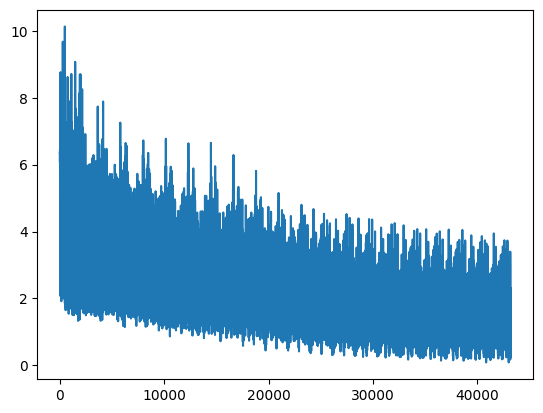

In [114]:
import matplotlib.pyplot as plt
plt.plot([i.item() for i in loss_record])

In [121]:
torch.save(net.state_dict(), './model_saved.pt')

In [115]:
def predict(net, tkn, h = None):
    # tensor inputs
    x = np.array([[token2int[tkn]]])
    inputs = torch.from_numpy(x)

    # push to GPU
    # inputs = inputs.cuda()

    # detach hidden state from history
    h = tuple([each.data for each in h])

    # get the output from model
    out, h = net(inputs, h)

    # get the token probabilities
    p = F.softmax(out, dim=1).data

    # p = p.cpu()

    p = p.numpy()
    p = p.reshape(p.shape[1],)

    # get indices of top 3 values
    top_n_idx = p.argsort()[-3:][::1]

    # randomly select one of the three indices
    sampled_token_index = top_n_idx[random.sample([0, 1, 2], 1)[0]]

    return int2token[sampled_token_index], h

def sample(net, size, prime='maj-0-'):
    # net.cuda()
    net.eval()
    # batch size is 1
    h = net.init_hidden(1)

    toks = prime.split()

    # predict next token
    for t in prime.split():
        token, h = predict(net, t, h)
    
    toks.append(token)

    # predict subsequent tokens
    for i in range(size-1):
        token, h = predict(net, toks[-1], h)
        toks.append(token)

    return ' '.join(toks)

In [124]:
sample(net, 15, 'maj-2-m7 maj-7-7')

'maj-2-m7 maj-7-7 maj-2-m7 maj-7-7sus4 maj-2-m maj-7- maj-2-m maj-5- maj-2-m maj-0- maj-0- maj-0- maj-0- maj-2-m maj-2-m maj-7- maj-5-'